#### This is the experiment and graph code of OthelloGPT using SAE.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# Imports
import torch
import matplotlib.pyplot as plt
from utils.dataloaders import get_dataloader
import utils.dataloaders
from tqdm import tqdm
from utils.game_engine import history_to_legal_moves
import utils.game_engine
from torcheval.metrics import BinaryAUROC
import pickle as pkl
import os
import sys
import numpy as np
import seaborn as sns
import analysis
from neel_plotly import line, scatter, imshow, histogram


c:\Users\Dolphin_\anaconda3\envs\cs194\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Dolphin_\anaconda3\envs\cs194\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# GPU acceleration
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# output stream rewrite for log files
class Tee:
    def __init__(self, filepath):
        self.file = open(filepath, "w")
        self.stdout = sys.stdout

    def write(self, message):
        self.file.write(message)
        self.stdout.write(message)

    def flush(self):
        self.file.flush()
        self.stdout.flush()

    def close(self):
        self.file.close()


# tee = Tee("output.log")
# sys.stdout = tee
# ...
# sys.stdout = sys.__stdout__
# tee.close()

#### Train linear_probe on all layers

In [4]:
from model_training import full_probe_run

tee = Tee("output.log")
sys.stdout = tee

layers = list(range(0, 8))
for layer in layers:
    full_probe_run(layer)

sys.stdout = sys.__stdout__
tee.close()

e:\CS194\Papers\OthelloSAE\model_training.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  language_model=torch.load(f, map_location=device)


Beginning model training on cpu!


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/probe_train_corpus.txt'

In [5]:
# Plot probe training acc
import re

log_file_path = "probe_train_output.log"
layer_pattern = re.compile(r"Train loss and test accuracy after Omega steps: .*?, (\d+\.\d+)%")
with open(log_file_path, 'r') as f:
    log_content = f.read()
accuracies = [float(match) for match in layer_pattern.findall(log_content)]
layers = list(range(len(accuracies)))

plt.figure(figsize=(10, 6))
plt.plot(layers, accuracies, marker='o', linestyle='-', label="Accuracy over Layers")
# Annotate each point with its accuracy value
for i, acc in enumerate(accuracies):
    plt.text(layers[i], acc, f"{acc:.2f}%", fontsize=9, ha='center', va='bottom')
plt.title("Linear Probe Accuracy Across Layers")
plt.xlabel("Layer")
plt.ylabel("Test Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(len(layers)), [f"Layer {i}" for i in layers])
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'probe_train_output.log'

In [9]:
model_location = "trained_model_full.pkl"
with open(model_location, 'rb') as f:
    othello_gpt=torch.load(f, map_location=device)

In [66]:
layers = list(range(0,8))
mode = 2 # ["empty", "own", "enemy"]
threshold = 0.1

for layer in layers:
    # Probe
    probe_path = f"probes/probe_layer_{layer}_trimmed.pkl"
    full_linear_probe = torch.load(probe_path)
    my_probe_W = full_linear_probe[f'classifier.{mode}.weight'] # (64, 512)
    my_probe_W = my_probe_W.t()
    my_probe_W[:, [27, 28, 35, 36]] = 0.
    my_probe_normalised = my_probe_W / my_probe_W.norm(dim=0, keepdim=True) # torch.Size([512, 64])
    my_probe_normalised[my_probe_normalised.isnan()] = 0.

    # Weight
    weight_in_key = f"blocks.{layer}.mlp_sublayer.encode.weight"
    
    heatmaps_my = []
    w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
    w_in /= w_in.norm(dim=0, keepdim=True)
    for neuron in range(0, 2048):
        neuron_weight = w_in[neuron, :]
        heatmaps_my.append((neuron_weight[:, None] * my_probe_normalised).sum(dim=0))
        
    heatmaps_my = torch.stack(heatmaps_my)
    heatmaps_my_id = (heatmaps_my.abs()>threshold).sum(dim=1).argsort(descending=True)[:10]
    heatmaps_my = heatmaps_my.reshape(-1, 8, 8)
    # print(heatmaps_my.shape)
    heatmaps_my = heatmaps_my[heatmaps_my_id]

    imshow(heatmaps_my,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Input weights and the my color probe for top layer {layer+1} neurons",
        facet_labels=[f"L{layer+1}N{n.item()}" for n in heatmaps_my_id],
        range_color=[-0.5, 0.5])

#### Histogram

torch.Size([2048, 64])


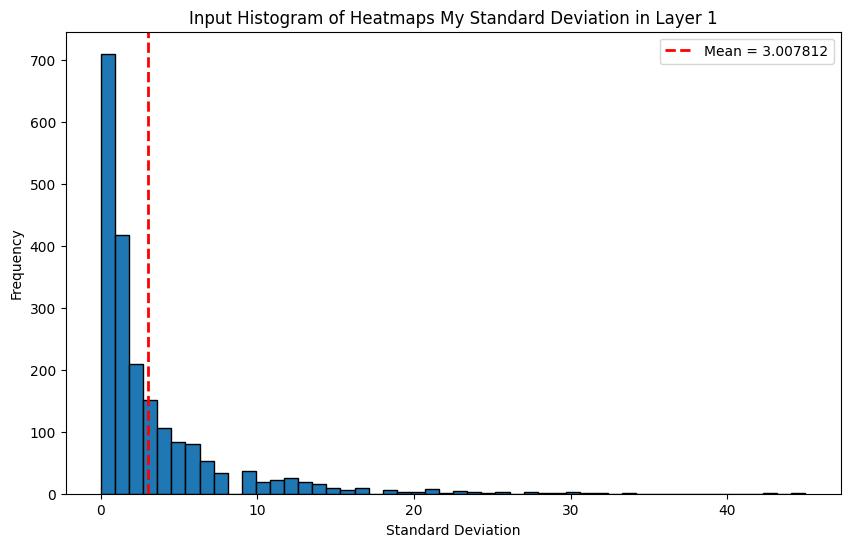

torch.Size([2048, 64])


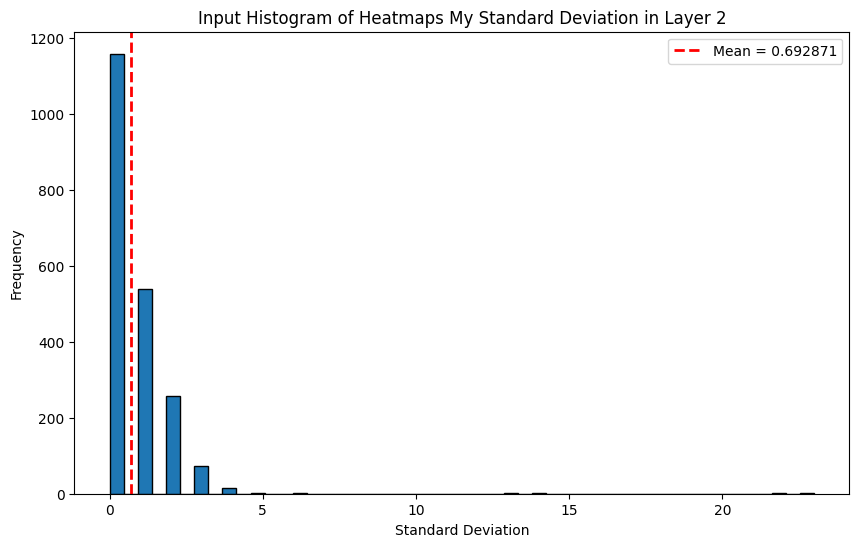

torch.Size([2048, 64])


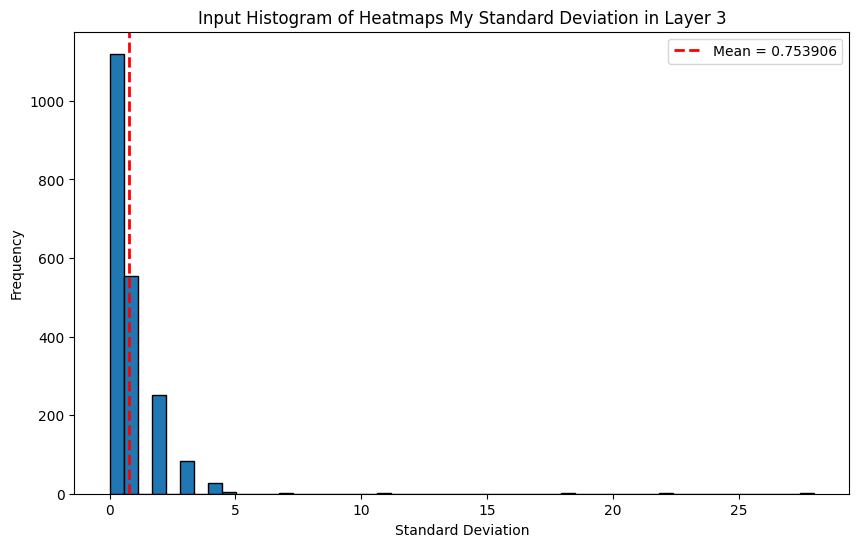

torch.Size([2048, 64])


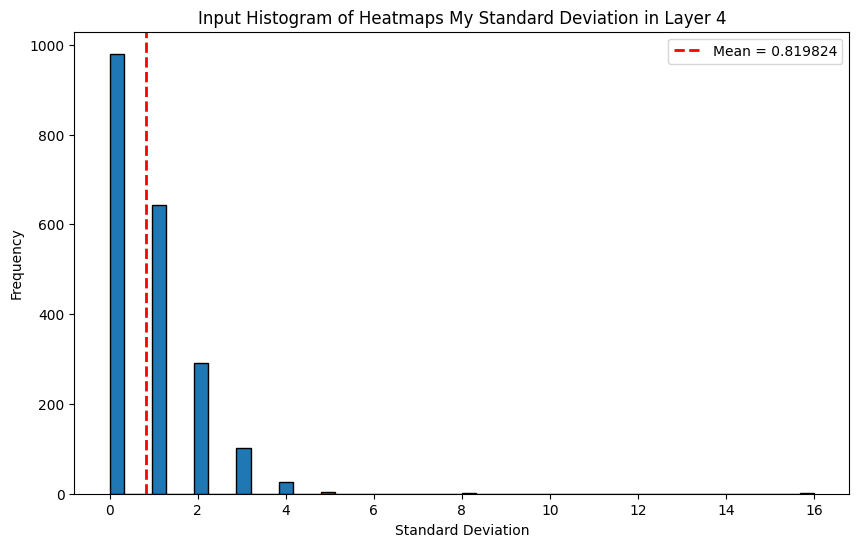

torch.Size([2048, 64])


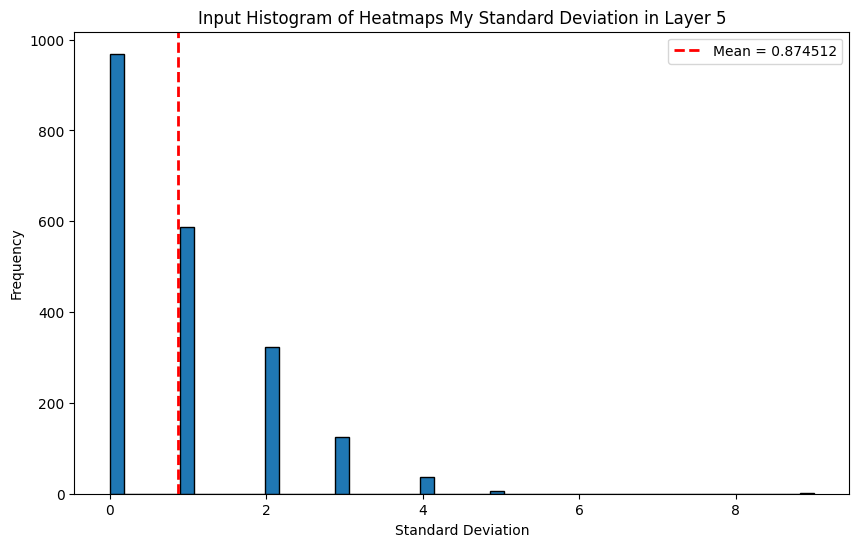

torch.Size([2048, 64])


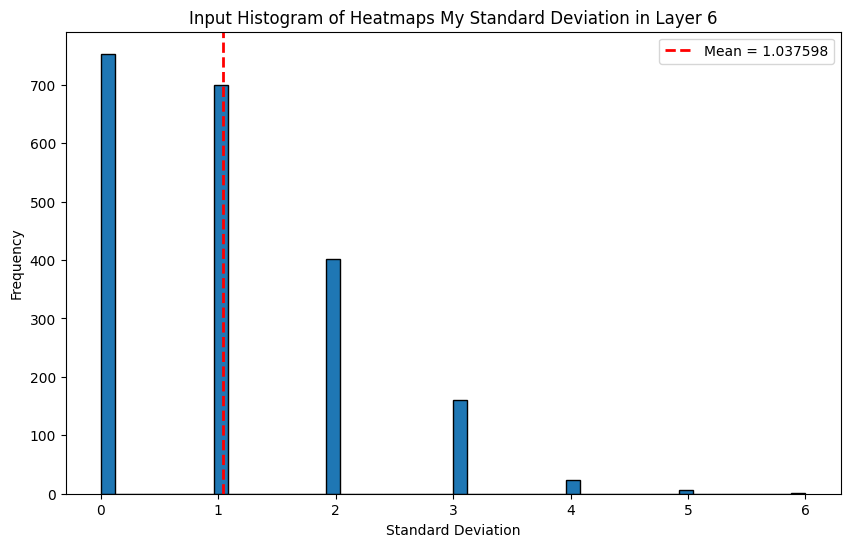

torch.Size([2048, 64])


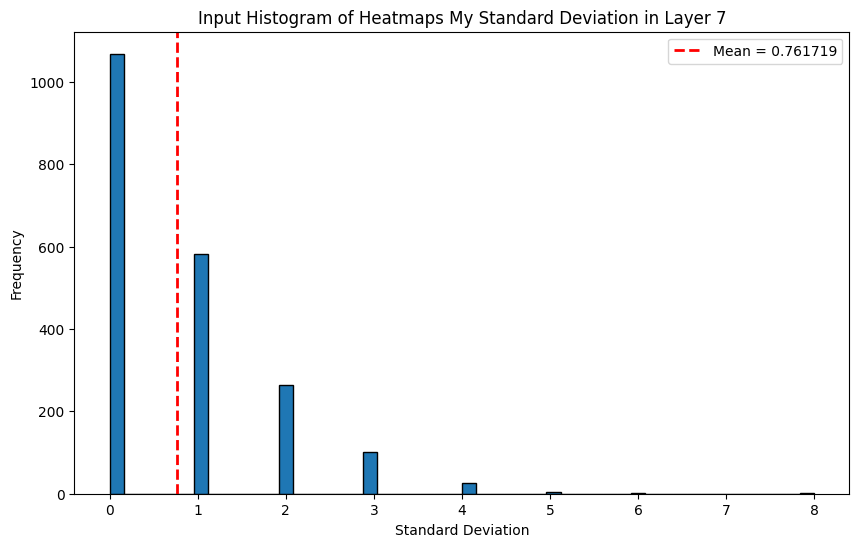

torch.Size([2048, 64])


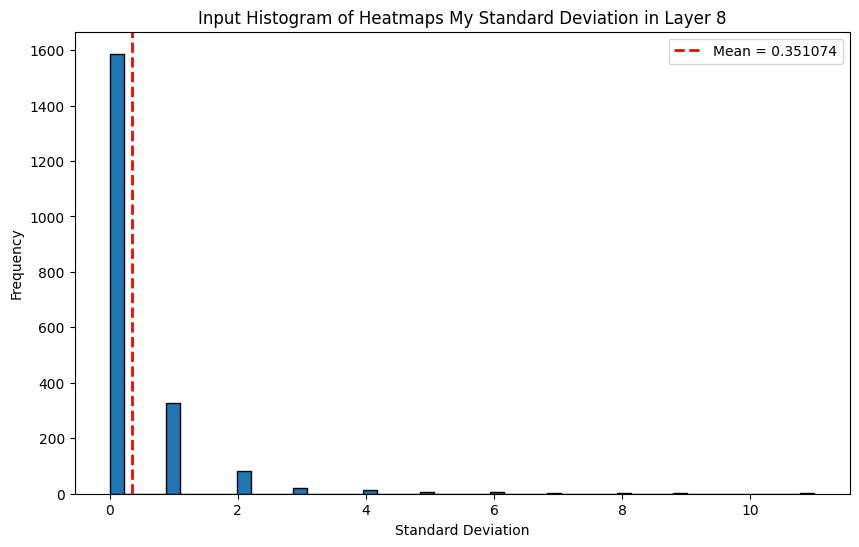

In [67]:
layers = list(range(0,8))
mode = 2 # ["empty", "own", "enemy"]

for layer in layers:
    # Probe
    probe_path = f"probes/probe_layer_{layer}_trimmed.pkl"
    full_linear_probe = torch.load(probe_path)
    my_probe_W = full_linear_probe[f'classifier.{mode}.weight'] # (64, 512)
    my_probe_W = my_probe_W.t()
    my_probe_W[:, [27, 28, 35, 36]] = 0.
    my_probe_normalised = my_probe_W / my_probe_W.norm(dim=0, keepdim=True) # torch.Size([512, 64])
    my_probe_normalised[my_probe_normalised.isnan()] = 0.
    # Weight
    weight_in_key = f"blocks.{layer}.mlp_sublayer.encode.weight"
    
    heatmaps_my = []
    w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
    w_in /= w_in.norm(dim=0, keepdim=True)
    for neuron in range(0, 2048):
        neuron_weight = w_in[neuron, :]
        heatmaps_my.append((neuron_weight[:, None] * my_probe_normalised).sum(dim=0))
        
        
    heatmaps_my = torch.stack(heatmaps_my)
    print(heatmaps_my.shape)
    
    if False:
        heatmaps_blank_std = heatmaps_blank.std(dim=[1, 2])
        mean_value = heatmaps_blank_std.mean().item()

        plt.figure(figsize=(10, 6))
        plt.hist(heatmaps_blank_std.detach().cpu().numpy(), bins=50, edgecolor='black')
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.4f}')
        plt.title(f"Input Histogram of Heatmaps Blank Standard Deviation in Layer {layer+1}")
        plt.xlabel("Standard Deviation")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
    else:
        heatmaps_my_std = (heatmaps_my.abs()>threshold).sum(dim=1).float()

        mean_value = heatmaps_my_std.mean().item()
        plt.figure(figsize=(10, 6))
        plt.hist(heatmaps_my_std.detach().cpu().numpy(), bins=50, edgecolor='black')
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.6f}')
        plt.title(f"Input Histogram of Heatmaps My Standard Deviation in Layer {layer+1}")
        plt.xlabel("Standard Deviation")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()